In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2

class Classifier(object):
    def __init__(self, reads, label, genes):
        self.reads = reads
        self.label = label
        self.genes = genes
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.y_test = []
        self.svm = SVC() # will be updated after the grid search
        self.rf = RandomForestClassifier()
        self.knn = KNeighborsClassifier()

    def preprossessing(self):
        '''This function calls the preprocess_label and preprocess_reads functions and merge two dataframes
        '''
        self.preprocess_reads()
        self.preprocess_label()
        data = pd.merge(self.reads, self.label, on='sample_ID', how='inner') # merge two dataframes
        newname = data.columns[1:-1].str.split('.').str[0]
        data.rename(columns=dict(zip(data.columns[1:-1], newname)), inplace=True)
        print('The shape of dataframe after merging is: ', data.shape)
        self.data = data
        print('-'*14, 'Finish preprocessing', '-'*14, '\n')
    
    def preprocess_label(self):
        '''This function merges some substages into one stage, drop the samples with no diagnosis, 
        and drop the samples with "not reported" diagnosis
        '''
        print('Processing labels')
        label = self.label
        label.loc[label['tumor_stage.diagnoses'] == 'stage ia', 'tumor_stage.diagnoses'] = 'stage i'
        label.loc[label['tumor_stage.diagnoses'] == 'stage ib', 'tumor_stage.diagnoses'] = 'stage i'
        label.loc[label['tumor_stage.diagnoses'] == 'stage iia', 'tumor_stage.diagnoses'] = 'stage ii'
        label.loc[label['tumor_stage.diagnoses'] == 'stage iib', 'tumor_stage.diagnoses'] = 'stage ii'
        label.loc[label['tumor_stage.diagnoses'] == 'stage iiia', 'tumor_stage.diagnoses'] = 'stage iii'
        label.loc[label['tumor_stage.diagnoses'] == 'stage iiib', 'tumor_stage.diagnoses'] = 'stage iii'
        label.loc[label['tumor_stage.diagnoses'] == 'stage iiic', 'tumor_stage.diagnoses'] = 'stage iii'
        label = label.loc[:, ['submitter_id.samples', 'tumor_stage.diagnoses']].rename(columns={'submitter_id.samples':'sample_ID', 'tumor_stage.diagnoses': 'diagnosis'})
        label.dropna(inplace=True) # drop samples with no diagnosis
        label = label.query('diagnosis != "not reported"') # exclude samples with 'not reported' diagnoses
        label = label.query('diagnosis != "stage x"') # exclude samples with 'not reported' diagnoses

        self.label = label
        print('After processing, the shape of the label dataframe is:', label.shape)
        print('Summary of labels:\n', label.diagnosis.value_counts())
        print('Finish processing labels')
        return label
    
    def preprocess_reads(self):
        '''This function transposes the reads dataframe, rename the first column into sample_ID to prepare for merging, duplicates and NA are also dropped'''
        print('Processing reads')
        print('This procedure may take 30 seconds to 1 minute.')
        reads = self.reads.set_index('Ensembl_ID').T
        reads.reset_index(inplace=True)
        reads.dropna(inplace=True)
        reads.drop_duplicates(inplace=True)
        reads.rename(columns={'index':'sample_ID'}, inplace=True)
        print('After processing, the shape of the reads dataframe is:', reads.shape)
        print('Finish processing reads')
        self.reads = reads
        reads.to_csv('reads.txt', index=False)

    def train_test_split(self):
        '''First convert the label to binary numerical values, then split the data into training and testing sets;
        A label dictionary is created to map the numerical values back to the original labels
        '''
        print('Splitting data')
        y = self.data['diagnosis']
        X = self.data.drop(['sample_ID', 'diagnosis'], axis=1)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3)
        print('The shape of training set is: ', self.X_train.shape)
        print('The shape of testing set is: ', self.X_test.shape)
        print('Finish splitting data')

    def train_test(self):
        '''This function calls three models (SVM, RF, KNN) to train the data'''
        print('SVM, RF, and KNN will be used to train the data.')
        self.train_svm()
        self.train_rf()
        self.train_knn()
        print('\n')
        
    def train_svm(self):
        '''This function trains the SVM model'''
        print('Training SVM...')
        self.svm.fit(self.X_train, self.y_train)
        ypred_svm = self.svm.predict(self.X_test)
        print('The accuracy of SVM is: ', accuracy_score(self.y_test, ypred_svm))
        print('The confusion matrix of SVM is: \n', confusion_matrix(self.y_test, ypred_svm))
        print('\n')
    
    def train_rf(self):
        '''This function trains the RF model'''
        print('Training RF...')
        self.rf.fit(self.X_train, self.y_train)
        ypred_rf = self.rf.predict(self.X_test)
        print('The accuracy of RF is: ', accuracy_score(self.y_test, ypred_rf))
        print('The confusion matrix of RF is: \n', confusion_matrix(self.y_test, ypred_rf))
        print('\n')

    def train_knn(self):
        '''This function trains the KNN model'''
        print('Training KNN...')
        self.knn.fit(self.X_train, self.y_train)
        ypred_knn = self.knn.predict(self.X_test)
        print('The accuracy of KNN is: ', accuracy_score(self.y_test, ypred_knn))
        print('The confusion matrix of KNN is: \n', confusion_matrix(self.y_test, ypred_knn))
        print('\n')

    def hyperparameter_tuning(self):
        '''GridSearchCV is used to find the best parameters for the selected model, this process may take a long while to finish.'''
        print('-'*10, 'Hyperparameter tuning', '-'*10)
        svm_params = {
            'kernel':['linear', 'sigmoid', 'poly', 'rbf'],
            'gamma':['auto', 'scale'],
        }
        grid1 = GridSearchCV(SVC(), svm_params, cv=3, verbose=3)
        grid1.fit(self.X_train, self.y_train)
        print('The best parameters for SVM are:', grid1.best_params_)
        self.svm = grid1.best_estimator_ # save the best svm model
        print('SVM has been updated.')
        print('Evaluate the performance on test set...')
        ypred1 = grid1.predict(self.X_test)
        print('Accuracy:', accuracy_score(self.y_test, ypred1))
        print('Confusion matrix: \n', confusion_matrix(self.y_test, ypred1))

        rf_params = {
            'bootstrap': [True, False],
            'max_depth': [5, 50, 100, None],
            'max_features': [20, 50, 80],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [10, 100, 200]
        }
        grid2 = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, verbose=3, n_jobs=-1)
        grid2.fit(self.X_train, self.y_train)
        print('The best parameters for RF are:', grid2.best_params_)
        self.rf = grid2.best_estimator_ # save the best rf model
        print('RF has been updated.')
        print('Evaluate the performance on test set')
        ypred2 = grid2.predict(self.X_test)
        print('Accuracy:', accuracy_score(self.y_test, ypred2))
        print('Confusion matrix: \n', confusion_matrix(self.y_test, ypred2))

        knn_params = {'n_neighbors':[5, 10, 20, 50, 100]}
        grid3 = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, verbose=3, n_jobs=-1)
        grid3.fit(self.X_train, self.y_train)
        print('The best parameters for KNN are:', grid3.best_params_)
        self.knn = grid3.best_estimator_ # save the best knn model
        print('KNN has been updated.')
        print('Evaluate the performance on test set')
        ypred3 = grid3.predict(self.X_test)
        print('Accuracy:', accuracy_score(self.y_test, ypred3))
        print('Confusion matrix: \n', confusion_matrix(self.y_test, ypred3))

    def feature_selection(self):
        '''Six methods are called by this method. The first three are three ways to select features, the last three are three ways to evaluate the importance of features.'''
        self.feature_selection_variance()
        self.feature_selection_chi2()
        self.feature_selection_prior(self.genes)
        self.training1()
        self.training2()
        self.training3()

    def feature_selection_variance(self):
        '''This function uses variance threshold (0.5) to select features'''
        selector = VarianceThreshold(threshold=0.5)
        selector.fit(self.X_train)
        self.X_train1 = selector.transform(self.X_train)
        self.X_test1 = selector.transform(self.X_test)
        print(f'Feature selection: [{self.X_test1.shape[1]}] features with variance > 0.5 are selected.')
        
    def feature_selection_chi2(self):
        '''This function selects genes based on chi2 test'''
        selector = SelectKBest(chi2, k=20)
        selector.fit(self.X_train, self.y_train)
        self.X_train2 = selector.transform(self.X_train)
        self.X_test2 = selector.transform(self.X_test)
        print(f'Feature selection: [{self.X_test2.shape[1]}] features with p-value < 0.01 are selected.')

    def feature_selection_prior(self, genes):
        '''This function selects genes that are mentioned in the literature'''
        ID = genes['ID']
        self.X_train3 = self.X_train.loc[:, ID]
        self.X_test3 = self.X_test.loc[:, ID]
        print(f'Feature selection: [{self.X_test3.shape[1]}] features are selected based on literature.')

    def training1(self):
        '''This function trains the models using the first set of selected features'''
        print('Performance of different models using the first set of selected features:')
        self.svm.fit(self.X_train1, self.y_train)
        ypred1 = self.svm.predict(self.X_test1)
        print('The accuracy of SVM is: ', accuracy_score(self.y_test, ypred1))
        print('The confusion matrix of SVM is: \n', confusion_matrix(self.y_test, ypred1))
        self.rf.fit(self.X_train1, self.y_train)
        ypred2 = self.rf.predict(self.X_test1)
        print('The accuracy of RF is: ', accuracy_score(self.y_test, ypred2))
        print('The confusion matrix of RF is: \n', confusion_matrix(self.y_test, ypred2))
        self.knn.fit(self.X_train1, self.y_train)
        ypred3 = self.knn.predict(self.X_test1)
        print('The accuracy of KNN is: ', accuracy_score(self.y_test, ypred3))
        print('The confusion matrix of KNN is: \n', confusion_matrix(self.y_test, ypred3))
        print('\n')

    def training2(self):
        '''This function trains the models using the second set of selected features'''
        print('Performance of different models using the second set of selected features:')
        self.svm.fit(self.X_train2, self.y_train)
        ypred1 = self.svm.predict(self.X_test2)
        print('The accuracy of SVM is: ', accuracy_score(self.y_test, ypred1))
        print('The confusion matrix of SVM is: \n', confusion_matrix(self.y_test, ypred1))
        self.rf.fit(self.X_train2, self.y_train)
        ypred2 = self.rf.predict(self.X_test2)
        print('The accuracy of RF is: ', accuracy_score(self.y_test, ypred2))
        print('The confusion matrix of RF is: \n', confusion_matrix(self.y_test, ypred2))
        self.knn.fit(self.X_train2, self.y_train)
        ypred3 = self.knn.predict(self.X_test2)
        print('The accuracy of KNN is: ', accuracy_score(self.y_test, ypred3))
        print('The confusion matrix of KNN is: \n', confusion_matrix(self.y_test, ypred3))
        print('\n')
    
    def training3(self):
        '''This function trains the models using the third set of selected features'''
        print('Performance of different models using the third set of selected features:')
        self.svm.fit(self.X_train3, self.y_train)
        ypred1 = self.svm.predict(self.X_test3)
        print('The accuracy of SVM is: ', accuracy_score(self.y_test, ypred1))
        print('The confusion matrix of SVM is: \n', confusion_matrix(self.y_test, ypred1))
        self.rf.fit(self.X_train3, self.y_train)
        ypred2 = self.rf.predict(self.X_test3)
        print('The accuracy of RF is: ', accuracy_score(self.y_test, ypred2))
        print('The confusion matrix of RF is: \n', confusion_matrix(self.y_test, ypred2))
        self.knn.fit(self.X_train3, self.y_train)
        ypred3 = self.knn.predict(self.X_test3)
        print('The accuracy of KNN is: ', accuracy_score(self.y_test, ypred3))
        print('The confusion matrix of KNN is: \n', confusion_matrix(self.y_test, ypred3))
        print('\n')

In [4]:
if __name__ == '__main__':
    print('Start loading data...')
    genes = pd.read_csv('genes.txt', sep='\t', header=0)
    genes = genes.drop(['Unnamed: 2'], axis=1).rename(columns={'Gene Symbol': 'symbol', 'Ensembl Gene ID': 'ID'})
    reads = pd.read_csv('TCGA-BRCA.htseq_fpkm.tsv', sep='\t', header=0)
    label = pd.read_csv('TCGA-BRCA.GDC_phenotype.tsv', sep='\t', header=0)

    C = Classifier(reads, label, genes)
    C.preprocess_reads()
    # C.train_test_split()
    # C.train_test()
    # C.hyperparameter_tuning()
    # C.feature_selection()
    # print('Finished.')

Start loading data...
Processing reads
This procedure may take 30 seconds to 1 minute.
After processing, the shape of the reads dataframe is: (1217, 60484)
Finish processing reads


In [5]:
C.train_test()

SVM, RF, and KNN will be used to train the data.
Training SVM...
The accuracy of SVM is:  0.5642458100558659
The confusion matrix of SVM is: 
 [[  0  62   0   0]
 [  0 202   0   0]
 [  0  86   0   0]
 [  0   8   0   0]]


Training RF...
The accuracy of RF is:  0.5642458100558659
The confusion matrix of RF is: 
 [[  1  61   0   0]
 [  2 199   1   0]
 [  0  84   2   0]
 [  0   8   0   0]]


Training KNN...
The accuracy of KNN is:  0.4692737430167598
The confusion matrix of KNN is: 
 [[ 16  38   8   0]
 [ 41 141  20   0]
 [ 12  63  11   0]
 [  3   3   2   0]]






In [3]:
X_train, X_test, y_train, y_test = C.X_train, C.X_test, C.y_train, C.y_test

In [12]:
# train svm on original data
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('The accuracy of SVM is: ', accuracy_score(y_test, y_pred))
print('The confusion matrix of SVM is: \n', confusion_matrix(y_test, y_pred))

The accuracy of SVM is:  0.5279329608938548
The confusion matrix of SVM is: 
 [[ 12  41   9   0]
 [ 19 149  38   0]
 [  4  49  28   0]
 [  0   4   5   0]]


In [13]:
# use chi2 test to select features
selector = SelectKBest(chi2, k=1000)
selector.fit(X_train, y_train)
X_train1 = selector.transform(X_train)
X_test1 = selector.transform(X_test)
print(f'Feature selection: [{X_test1.shape[1]}] features are selected by chi square.')

Feature selection: [1000] features are selected by chi square.


In [14]:
# use svm to predict
svm = SVC(kernel='linear')
svm.fit(X_train1, y_train)
ypred1 = svm.predict(X_test1)
print('The accuracy of SVM is: ', accuracy_score(y_test, ypred1))
print('The confusion matrix of SVM is: \n', confusion_matrix(y_test, ypred1))

The accuracy of SVM is:  0.42178770949720673
The confusion matrix of SVM is: 
 [[ 14  32  15   1]
 [ 43 113  50   0]
 [ 15  42  24   0]
 [  0   5   4   0]]


In [31]:
# use PCA to do dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_train1)
X_train2 = pca.transform(X_train1)
X_test2 = pca.transform(X_test1)
print(f'PCA: Current dimension is [{X_train2.shape[1]}].')

PCA: Current dimension is [10].


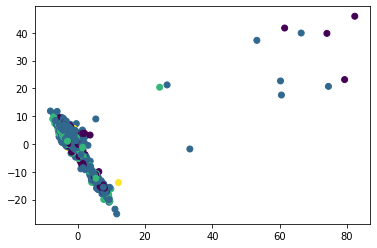

In [32]:
# visualize the pca result
import matplotlib.pyplot as plt
y_train_ = y_train.replace({'stage i': 1, 'stage ii': 2, 'stage iii': 3, 'stage iv': 4})
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=y_train_)
plt.show()

In [33]:
# use svm to predict
svm = SVC(kernel='linear')
svm.fit(X_train2, y_train)
ypred2 = svm.predict(X_test2)
print('The accuracy of SVM is: ', accuracy_score(y_test, ypred2))
print('The confusion matrix of SVM is: \n', confusion_matrix(y_test, ypred2))

The accuracy of SVM is:  0.5754189944134078
The confusion matrix of SVM is: 
 [[  0  62   0   0]
 [  0 206   0   0]
 [  0  81   0   0]
 [  0   9   0   0]]


In [34]:
X_test2.shape

(358, 10)